# Writing entry point script

In [1]:
%%writefile rf-train.py

# Used to train and load the model using Sagemaker API

import os
import argparse
import joblib
import time
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Loading model to predict
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "rf_model.joblib"))
    return clf

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--train-file', type=str, default="train.csv")
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--n_estimators', type=int, default=100)  # Add this line to accept the 'n_estimators' hyperparameter
    parser.add_argument('--max_depth', type=int, default=None)  # Add this line to accept the 'max_depth' hyperparameter
    args, _ = parser.parse_known_args()

    # Load training data from the SageMaker channel
    train_data = pd.read_csv(os.path.join(args.train, args.train_file))

    # Separate features and labels
    X = train_data.iloc[:, :-1].values
    y = train_data['label'].values

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

    # Instantiate and train the Random Forest model
    rf_classifier = RandomForestClassifier(n_estimators=args.n_estimators, max_depth=args.max_depth, random_state=0)
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the validation set
    val_predictions = rf_classifier.predict(X_val)

    # Calculate the validation accuracy
    val_accuracy = accuracy_score(y_val, val_predictions)

    # Print the validation accuracy
    print(f"Validation Accuracy: {val_accuracy}")

    # Save the trained model to the model directory
    model_path = os.path.join(args.model_dir, 'rf_model.joblib')
    joblib.dump(rf_classifier, model_path)

    print(f"Model saved at {model_path}")


Overwriting rf-train.py


# Header Declaration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import time

#Define IAM Role
import boto3
import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.predictor import Predictor
from sagemaker.sklearn.model import SKLearnModel
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter, CategoricalParameter

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# Sagemaker varaible declaration

In [3]:
# Set SageMaker and S3 client variables
sess = sagemaker.Session()

s3_region =  'us-east-1'
s3_client = boto3.client("s3", region_name=s3_region)
sm_boto3 = boto3.client("sagemaker")

sagemaker_role = sagemaker.get_execution_role()

bucket_name = 'bucket--ganesh'
read_prefix = 'Project/RF-try'

input_file_name = "advertising.csv"
train_file_name = "train.csv"

input_file_path = f"s3://{bucket_name}/{read_prefix}/Data/"
train_file_path = f"s3://{bucket_name}/{read_prefix}/Data/"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# Loading the data

In [4]:
# Load the data.
data = pd.read_csv(input_file_path + input_file_name)
data

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0
...,...,...,...,...,...,...,...,...,...,...
995,72.97,30,71384.57,208.58,Fundamental modular algorithm,Duffystad,1,Lebanon,2016-02-11 21:49:00,1
996,51.30,45,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,2016-04-22 02:07:01,1
997,51.63,51,42415.72,120.37,Expanded intangible solution,South Jessica,1,Mongolia,2016-02-01 17:24:57,1
998,55.55,19,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,2016-03-24 02:35:54,0


# Preprocessing the data

In [5]:
# Timestamp conversion to seconds
data['Timestamp'] = (pd.to_datetime(data['Timestamp']) - pd.to_datetime(data['Timestamp'][0])).dt.total_seconds()

# Drop non-integer columns
data = data.drop(columns=['Ad Topic Line', 'Country', 'City'])

# Extract features and target variable
X = data.iloc[:, 1:-1].values.astype('float64')
y = data['Clicked on Ad'].values

# Pre-processing - normalization of data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Write the training data to a file
trainX = pd.DataFrame(X_train)
trainX['label'] = y_train

trainX.to_csv(train_file_path + train_file_name, index=False, header=True)

# Check the working of the script

In [6]:
! python rf-train.py  --model-dir ./ \
                      --n_estimators 100 \
                      --max_depth 2 \
                      --train {train_file_path} \                   

Validation Accuracy: 0.9066666666666666
Model saved at ./rf_model.joblib


# Train the model

In [7]:
# Define the SageMaker Estimator
estimator = SKLearn(entry_point="rf-train.py",  # Your training script file
                    role=sagemaker_role,      # SageMaker IAM Role
                    instance_type="ml.m4.xlarge",  # Choose an appropriate instance type
                    sagemaker_session=sess,
                    framework_version="1.2-1",  # Your desired scikit-learn version
                    base_job_name="rf-training"
                  )

estimator.fit({'train': train_file_path})

INFO:sagemaker:Creating training-job with name: rf-training-2023-10-26-21-40-12-135


Using provided s3_resource
2023-10-26 21:40:12 Starting - Starting the training job...
2023-10-26 21:40:37 Starting - Preparing the instances for training.........
2023-10-26 21:42:12 Downloading - Downloading input data
2023-10-26 21:42:12 Training - Downloading the training image......
2023-10-26 21:42:47 Training - Training image download completed. Training in progress.2023-10-26 21:43:01,886 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-10-26 21:43:01,892 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-10-26 21:43:01,904 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-10-26 21:43:02,137 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-10-26 21:43:02,160 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-10-26 21:43:02,176 sagemaker-training-toolkit INFO     No GPUs detected (normal if no g

# Download the Artifacts of the trained Model

In [8]:
estimator.latest_training_job.wait(logs="None")
artifact = sm_boto3.describe_training_job(
    TrainingJobName=estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)


2023-10-26 21:43:31 Starting - Preparing the instances for training
2023-10-26 21:43:31 Downloading - Downloading input data
2023-10-26 21:43:31 Training - Training image download completed. Training in progress.
2023-10-26 21:43:31 Uploading - Uploading generated training model
2023-10-26 21:43:31 Completed - Training job completed
Model artifact persisted at s3://sagemaker-us-east-1-977473325382/rf-training-2023-10-26-21-40-12-135/output/model.tar.gz


# Create Endpoint for the model

In [9]:
model = SKLearnModel(
    model_data=artifact,
    role=sagemaker_role,
    entry_point="rf-train.py",
    framework_version="1.2-1",
)

# Deploy the trained model to an endpoint
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.large', endpoint_name='rf-endpoint')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2023-10-26-21-44-22-209
INFO:sagemaker:Creating endpoint-config with name rf-endpoint
INFO:sagemaker:Creating endpoint with name rf-endpoint


-----!

# Predict using the Endpoint

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       136
           1       0.90      0.97      0.93       114

    accuracy                           0.94       250
   macro avg       0.94      0.94      0.94       250
weighted avg       0.94      0.94      0.94       250



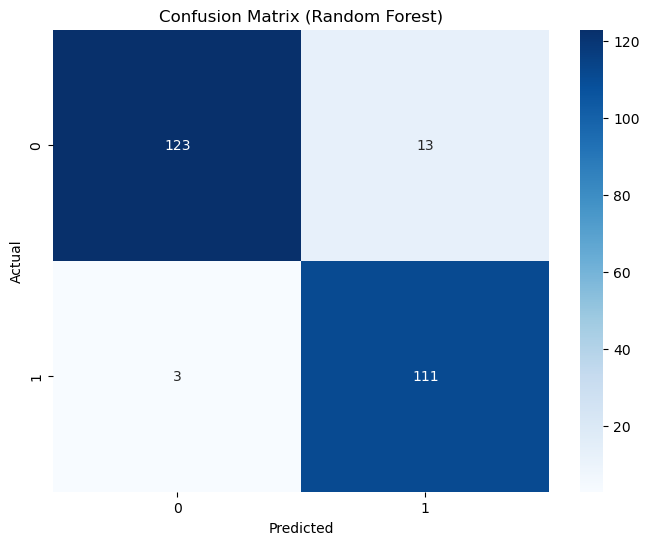

Accuracy using Random Forest: 93.60%


In [10]:
predictions = predictor.predict(X_test)
print(classification_report(y_test, predictions))

cnf_matrix_rf = confusion_matrix(y_test, predictions)

# Create a heatmap for the Random Forest confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_rf, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# Calculate and print accuracy
acc_rf = accuracy_score(y_test, predictions)
print(f"Accuracy using Random Forest: {acc_rf * 100:.2f}%")

# Hyperparameter Tuning

In [11]:
# Define hyperparameter ranges and strategy
hyperparameter_ranges = {
    'n_estimators': sagemaker.tuner.IntegerParameter(100, 200),
    'max_depth': sagemaker.tuner.IntegerParameter(5, 15),
}

objective_metric_name = 'validation:accuracy'

# Define the metric definition
metric_definitions = [{'Name': 'validation:accuracy', 'Regex': 'Accuracy: ([0-9.]+)'}]

# Create a HyperparameterTuner
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,  # Specify the metric definition here
    strategy='Bayesian',  # You can use other strategies like 'Bayesian' or 'Grid'
    max_jobs=10, # Number of hyperparameter combinations to try
    max_parallel_jobs=2, # Number of jobs to run in parallel
    base_tuning_job_name='rf-hyperparameter-tuning'
)

# Start hyperparameter tuning job
tuner.fit({'train': train_file_path})

# tuner.wait()

while True:
    # Check the status of the tuning job
    status = sm_boto3.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
    )['HyperParameterTuningJobStatus']
    
    if status == 'Completed':
        print("Hyperparameter tuning job has completed.")
        break
    elif status == 'Failed' or status == 'Stopped':
        print("Hyperparameter tuning job has failed or stopped.")
        break
    
    # Wait for a while before checking again
    time.sleep(60)  # You can adjust the polling interval



Using provided s3_resource


INFO:sagemaker:Creating hyperparameter tuning job with name: rf-hyperparameter-tu-231026-2148


............................................................................!
Hyperparameter tuning job has completed.


# Print each job details

In [12]:
# Retrieve the details of the completed hyperparameter tuning job
tuning_job_name = tuner.latest_tuning_job.job_name
training_job_summaries = sm_boto3.list_training_jobs_for_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)['TrainingJobSummaries']

# Get the best training job from SageMaker
tuning_job_description = sm_boto3.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

# Print hyperparameters and validation accuracy for each training job
results = []
for job_summary in training_job_summaries:
    job_name = job_summary['TrainingJobName']
    hyperparameters = job_summary['TunedHyperParameters']
    validation_metric = job_summary['FinalHyperParameterTuningJobObjectiveMetric']

    print(f"Job Name: {job_name}")
    print(f"Hyperparameters: {hyperparameters}")
    print(f"Validation Metric ({objective_metric_name}): {validation_metric}")
    print("")

    results.append({
        'TrainingJobName': job_name,
        'Hyperparameters': hyperparameters,
        'ValidationMetric': validation_metric
    })

# Retrieve the best training job based on SageMaker-selected objective metric
best_training_job_name = tuner.best_training_job()
best_training_job_description = sm_boto3.describe_training_job(TrainingJobName=best_training_job_name)
best_hyperparameters = best_training_job_description['HyperParameters']
best_validation_metric = best_training_job_description['FinalMetricDataList'][0]  # Assuming you want the first metric

print(f"Training Job Name: {best_training_job_name}")
print("Hyperparameters:")
for key, value in best_hyperparameters.items():
    print(f"  {key}: {value}")
print(f"Validation Metric ({objective_metric_name}): {best_validation_metric['Value']:.4f}")

# Convert the results to a DataFrame for further analysis if needed
results_df = pd.DataFrame(results)

Job Name: rf-hyperparameter-tu-231026-2148-010-48111ee2
Hyperparameters: {'max_depth': '15', 'n_estimators': '142'}
Validation Metric (validation:accuracy): {'MetricName': 'validation:accuracy', 'Value': 0.9200000166893005}

Job Name: rf-hyperparameter-tu-231026-2148-009-3068b164
Hyperparameters: {'max_depth': '14', 'n_estimators': '123'}
Validation Metric (validation:accuracy): {'MetricName': 'validation:accuracy', 'Value': 0.9200000166893005}

Job Name: rf-hyperparameter-tu-231026-2148-008-c0f2257d
Hyperparameters: {'max_depth': '15', 'n_estimators': '156'}
Validation Metric (validation:accuracy): {'MetricName': 'validation:accuracy', 'Value': 0.9200000166893005}

Job Name: rf-hyperparameter-tu-231026-2148-007-ad15087d
Hyperparameters: {'max_depth': '14', 'n_estimators': '177'}
Validation Metric (validation:accuracy): {'MetricName': 'validation:accuracy', 'Value': 0.9200000166893005}

Job Name: rf-hyperparameter-tu-231026-2148-006-03432b13
Hyperparameters: {'max_depth': '6', 'n_estim

# Create Endpoint for the best model

In [13]:
best_model = estimator.attach(best_training_job_name)

predictor = best_model.deploy(initial_instance_count=1, instance_type='ml.m5.large', endpoint_name='tuned-rf-endpoint')
sess.delete_endpoint('rf-endpoint')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml

2023-10-26 21:54:26 Starting - Found matching resource for reuse
2023-10-26 21:54:26 Downloading - Downloading input data
2023-10-26 21:54:26 Training - Training image download completed. Training in progress.
2023-10-26 21:54:26 Uploading - Uploading generated training model
2023-10-26 21:54:26 Completed - Resource retained for reuse

INFO:sagemaker:Creating model with name: rf-hyperparameter-tu-2023-10-26-21-55-36-539


INFO:sagemaker:Creating endpoint-config with name tuned-rf-endpoint
INFO:sagemaker:Creating endpoint with name tuned-rf-endpoint


----!

INFO:sagemaker:Deleting endpoint with name: rf-endpoint


# Predict with the best model

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       136
           1       0.90      0.97      0.93       114

    accuracy                           0.94       250
   macro avg       0.94      0.94      0.94       250
weighted avg       0.94      0.94      0.94       250



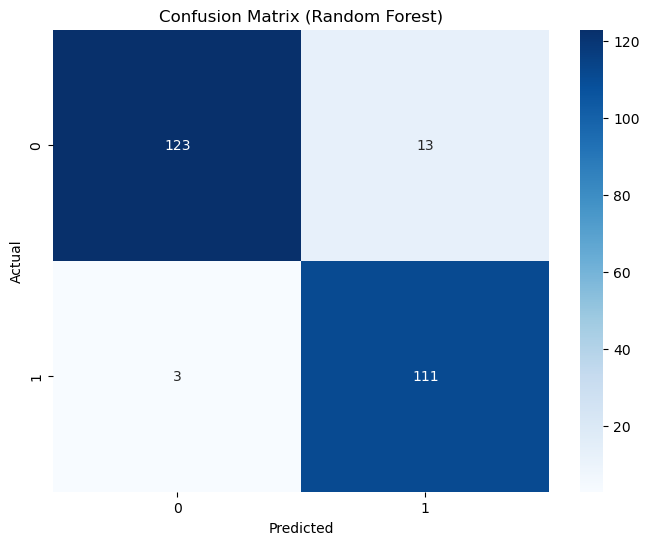

Accuracy using Random Forest: 93.60%


In [14]:
predictions = predictor.predict(X_test)
print(classification_report(y_test, predictions))

cnf_matrix_rf = confusion_matrix(y_test, predictions)

# Create a heatmap for the Random Forest confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_rf, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# Calculate and print accuracy
acc_rf = accuracy_score(y_test, predictions)
print(f"Accuracy using Random Forest: {acc_rf * 100:.2f}%")